### Connect to Colab

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Lecture 8

Mounted at /gdrive
/gdrive/My Drive/[2023-2024] AN2DL/Lecture 8


### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [4]:
import string
import re
import matplotlib.pyplot as plt
plt.rc('font', size=16)

### Load and process data

Dataset source: http://www.manythings.org/anki/

In [5]:
!head -42 ita.txt

Hi.	Ciao!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)
Hi.	Ciao.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4522287 (Guybrush88)
Run!	Corri!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906347 (Guybrush88)
Run!	Corra!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906348 (Guybrush88)
Run!	Correte!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906350 (Guybrush88)
Who?	Chi?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #2126402 (Guybrush88)
Wow!	Wow!	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #1922050 (Guybrush88)
Duck!	Amore!	CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #5502518 (Guybrush88)
Duck!	Tesoro!	CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #5502519 (Guybrush88)
Duck!	Immergiti!	CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #5502520 (Guybrush88)
Duck!	Si immerga!	CC-BY 2.0 (France) Attribution: tatoeba

In [ ]:
def read_txt(txt_file):
    """
    Read a text file and extract English and Italian sentence pairs.

    Args:
    txt_file (str): Path to the text file.

    Returns:
    list: A list of sentence pairs, each containing an English sentence and
          its Italian translation, with start and end tokens added to the Italian sentence.
    """
    sentences = []

    # Open the file using a with statement to ensure it's properly closed after reading
    with open(txt_file, encoding='utf-8') as file:
        for line in file:
            # Process only lines containing a tab character (assumed format: English\tItalian)
            if '\t' in line:
                eng_sentence, ita_sentence, *_ = line.rstrip().split('\t')
                # Append sentences with added start and end tokens for the Italian sentence
                sentences.append([eng_sentence, f"[start] {ita_sentence} [end]"])

    return sentences

In [ ]:
# Get english-italian sentence pairs
text_pairs = read_txt('ita.txt')

# Print some pair example
for _ in range(5):
    print(random.choice(text_pairs))

["Do you still have a key to Tom's apartment?", "[start] Voi avete ancora una chiave dell'appartamento di Tom? [end]"]
['Are they still mad?', '[start] Loro sono ancora arrabbiate? [end]']
['I like to eat.', '[start] A me piace mangiare. [end]']
['Tom did nothing but cry.', '[start] Tom non fece altro che piangere. [end]']
['Tom gave me some money.', "[start] Tom mi diede un po' di soldi. [end]"]


In [ ]:
def split_data(text_pairs, val_ratio=0.15, test_ratio=0.15):
    """
    Splits the data into training, validation, and test sets.

    Args:
    text_pairs (list): The complete dataset to be split.
    val_ratio (float): The proportion of data to be used for validation.
    test_ratio (float): The proportion of data to be used for testing.

    Returns:
    tuple: Three lists containing the training, validation, and test data respectively.
    """
    random.shuffle(text_pairs)

    num_samples = len(text_pairs)
    num_val_samples = int(val_ratio * num_samples)
    num_test_samples = int(test_ratio * num_samples)
    num_train_samples = num_samples - num_val_samples - num_test_samples

    train_pairs = text_pairs[:num_train_samples]
    val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
    test_pairs = text_pairs[num_train_samples + num_val_samples :]

    return train_pairs, val_pairs, test_pairs

train_pairs, val_pairs, test_pairs = split_data(text_pairs)

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

358373 total pairs
250863 training pairs
53755 validation pairs
53755 test pairs


In [ ]:
# Define a list of characters to strip from input text, excluding "[" and "]"
# Additionally, the '¿' character, which is not included in the standard punctuation set, is appended to this customized set.
strip_chars = string.punctuation.replace("[", "").replace("]", "") + "¿"

vocab_size = 20000
sequence_length = 32

def custom_standardization(input_string):
    """
    Standardize the input string by converting it to lowercase and removing specified characters.

    Args:
    input_string (tf.Tensor): The input text tensor.

    Returns:
    tf.Tensor: The standardized text tensor.
    """
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Initialize vectorization layers for English and Italian texts
eng_vectorization = tfkl.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length
)

ita_vectorization = tfkl.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization
)

train_eng_texts = [pair[0] for pair in train_pairs]
train_ita_texts = [pair[1] for pair in train_pairs]

eng_vectorization.adapt(train_eng_texts)
ita_vectorization.adapt(train_ita_texts)

In [ ]:
def format_dataset(eng, ita):
    """
    Formats the dataset by vectorizing the English and Italian texts and preparing encoder and decoder inputs.

    Args:
    eng (tf.Tensor): Batch of English text.
    ita (tf.Tensor): Batch of Italian text.

    Returns:
    tuple: A tuple containing a dictionary of encoder and decoder inputs, and the target sequence.
    """
    eng = eng_vectorization(eng)
    ita = ita_vectorization(ita)
    return {"encoder_inputs": eng, "decoder_inputs": ita[:, :-1]}, ita[:, 1:]

def make_dataset(pairs, batch_size):
    """
    Creates a TensorFlow dataset from English-Italian text pairs.

    Args:
    pairs (list): List of tuples containing English and Italian text pairs.
    batch_size (int): Size of the batches in the dataset.

    Returns:
    tf.data.Dataset: The formatted and batched dataset.
    """
    eng_texts, ita_texts = zip(*pairs)
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(ita_texts)))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(tf.data.AUTOTUNE).cache()

# Example usage with training and validation data
batch_size = 256
train_ds = make_dataset(train_pairs, batch_size)
val_ds = make_dataset(val_pairs, batch_size)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (256, 32)
inputs["decoder_inputs"].shape: (256, 32)
targets.shape: (256, 32)


### Transformer

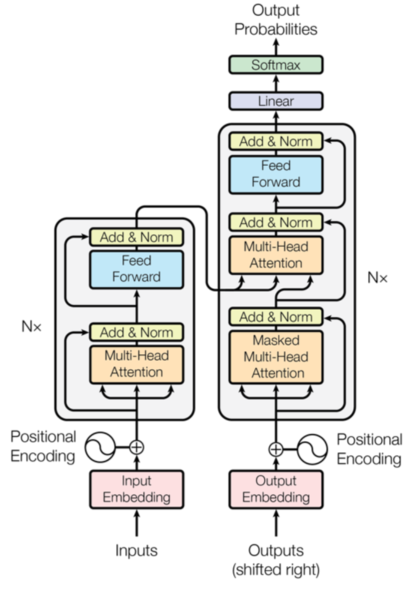

In [ ]:
class TokenAndPositionEmbedding(tfkl.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        """
        Initialize the layers for token and position embeddings.

        Args:
        maxlen (int): The maximum length of the input sequences.
        vocab_size (int): The size of the vocabulary.
        embed_dim (int): The dimension of the embedding vectors.
        """
        super().__init__(**kwargs)
        self.token_emb = tfkl.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        """
        Perform the embedding of tokens and positions and return their sum.

        Args:
        x (tf.Tensor): The input tensor containing token indices.

        Returns:
        tf.Tensor: The tensor resulting from adding token and position embeddings.
        """
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
class TransformerEncoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        """
        Initialize the Transformer Encoder Block.

        Args:
        embed_dim (int): Dimension of the embedding layer.
        num_heads (int): Number of attention heads.
        ff_dim (int): Dimension of the feed-forward network.
        rate (float): Dropout rate.
        """
        super().__init__(**kwargs)
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential([tfkl.Dense(ff_dim, activation="relu"), tfkl.Dense(embed_dim)])
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfkl.Dropout(rate)
        self.dropout2 = tfkl.Dropout(rate)

    def call(self, inputs, training):
        """
        Process the input through the Transformer Encoder Block.

        Args:
        inputs (tf.Tensor): Input tensor for the encoder block.
        training (bool): Indicates whether the model is in training mode.

        Returns:
        tf.Tensor: The output of the encoder block.
        """
        attn_output = self.att(inputs, inputs)  # Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Add & Normalize

        ffn_output = self.ffn(out1)  # Feed-forward network
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Add & Normalize

In [ ]:
class TransformerDecoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        """
        Initialize the Transformer Decoder Block.

        Args:
        embed_dim (int): Dimension of the embedding layer.
        num_heads (int): Number of attention heads.
        ff_dim (int): Dimension of the feed-forward network.
        rate (float): Dropout rate.
        """
        super().__init__(**kwargs)
        self.att1 = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att2 = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential([tfkl.Dense(ff_dim, activation="relu"), tfkl.Dense(embed_dim)])
        self.layernorm1, self.layernorm2, self.layernorm3 = [tfkl.LayerNormalization(epsilon=1e-6) for _ in range(3)]
        self.dropout1, self.dropout2, self.dropout3 = [tfkl.Dropout(rate) for _ in range(3)]

    def call(self, inputs, encoder_outputs, training, mask=None):
        """
        Process the input through the Transformer Decoder Block.

        Args:
        inputs (tf.Tensor): Input tensor for the decoder block.
        encoder_outputs (tf.Tensor): Output tensor from the encoder.
        training (bool): Indicates whether the model is in training mode.
        mask (tf.Tensor, optional): Optional mask for the inputs.

        Returns:
        tf.Tensor: The output of the decoder block.
        """
        causal_mask = self.get_causal_attention_mask(inputs)
        padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32") if mask is not None else None
        padding_mask = tf.minimum(padding_mask, causal_mask) if mask is not None else None

        attn_output_1 = self.att1(inputs, inputs, inputs, attention_mask=causal_mask)
        attn_output_1 = self.dropout1(attn_output_1, training=training)
        out_1 = self.layernorm1(inputs + attn_output_1)

        attn_output_2 = self.att2(out_1, encoder_outputs, encoder_outputs, attention_mask=padding_mask)
        attn_output_2 = self.dropout2(attn_output_2, training=training)
        out_2 = self.layernorm2(out_1 + attn_output_2)

        ffn_output = self.ffn(out_2)
        ffn_output = self.dropout3(ffn_output, training=training)

        return self.layernorm3(out_2 + ffn_output)

    def get_causal_attention_mask(self, inputs):
        """
        Creates a causal attention mask to prevent the model from attending to future timesteps.

        Args:
        inputs (tf.Tensor): The input tensor.

        Returns:
        tf.Tensor: The causal attention mask.
        """
        batch_size, sequence_length = tf.shape(inputs)[0], tf.shape(inputs)[1]
        i, j = tf.range(sequence_length)[:, tf.newaxis], tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        return tf.tile(tf.reshape(mask, (1, sequence_length, sequence_length)), [batch_size, 1, 1])

In [ ]:
# Define Transformer hyperparameters
embed_dim = 128
latent_dim = 1024
num_heads = 4

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer  [(None, None)]            0         
 )                                                               
                                                                 
 token_and_position_embeddi  (None, None, 128)         2564096   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_encoder_block   (None, None, 128)         527616    
 (TransformerEncoderBlock)                                       
                                                                 
Total params: 3091712 (11.79 MB)
Trainable params: 3091712 (11.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


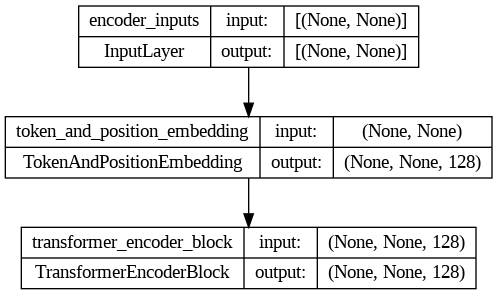

In [ ]:
def create_encoder(sequence_length, vocab_size, embed_dim, num_heads, latent_dim):
    """
    Creates an encoder model using token and position embeddings, and a transformer encoder block.

    Args:
    sequence_length (int): The maximum sequence length of the input.
    vocab_size (int): The size of the vocabulary.
    embed_dim (int): The dimension of the embedding vectors.
    num_heads (int): The number of attention heads in the transformer.
    latent_dim (int): The dimension of the latent space in the feed-forward network of the transformer.

    Returns:
    tfk.Model: The encoder model.
    """
    encoder_inputs = tfk.Input(shape=(None,), dtype="int64", name="encoder_inputs")
    x = TokenAndPositionEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
    encoder_outputs = TransformerEncoderBlock(embed_dim, num_heads, latent_dim)(x)
    encoder = tfk.Model(encoder_inputs, encoder_outputs, name="Encoder")

    return encoder

encoder = create_encoder(sequence_length, vocab_size, embed_dim, num_heads, latent_dim)

# Display summary and plot the model
encoder.summary(expand_nested=True)
tfk.utils.plot_model(encoder, show_shapes=True, expand_nested=True, to_file='encoder_model.png')

Model: "Decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 token_and_position_embeddi  (None, None, 128)            2564096   ['decoder_inputs[0][0]']      
 ng_1 (TokenAndPositionEmbe                                                                       
 dding)                                                                                           
                                                                                                  
 decoder_state_inputs (Inpu  [(None, None, 128)]          0         []                      

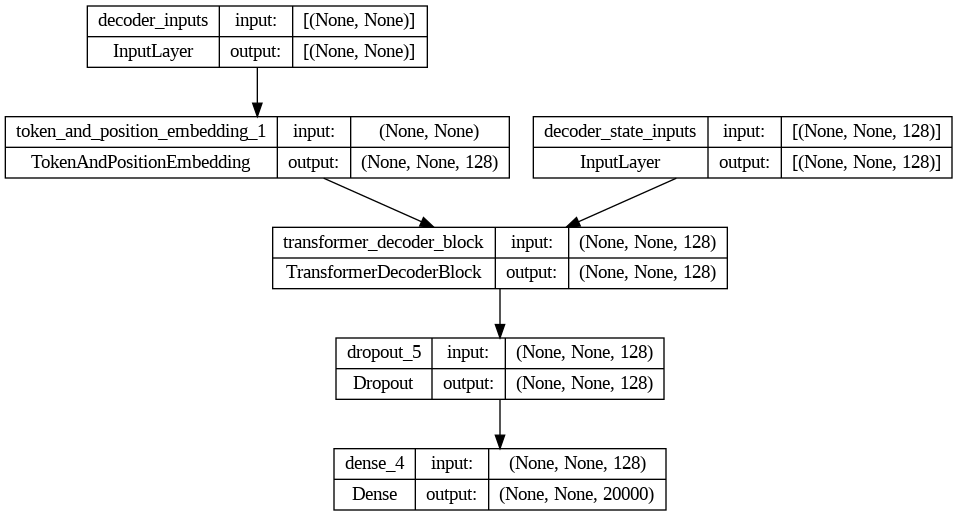

In [ ]:
def create_decoder(sequence_length, vocab_size, embed_dim, num_heads, latent_dim):
    """
    Creates a decoder model using token and position embeddings, a transformer decoder block,
    followed by dropout and a dense softmax layer.

    Args:
    sequence_length (int): Maximum sequence length of the input.
    vocab_size (int): Size of the vocabulary.
    embed_dim (int): Dimension of the embedding vectors.
    num_heads (int): Number of attention heads in the transformer.
    latent_dim (int): Dimension of the latent space in the feed-forward network of the transformer.

    Returns:
    tfk.Model: The decoder model.
    """
    decoder_inputs = tfk.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    encoded_seq_inputs = tfk.Input(shape=(None, embed_dim), name="decoder_state_inputs")

    x = TokenAndPositionEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
    x = TransformerDecoderBlock(embed_dim, num_heads, latent_dim)(x, encoded_seq_inputs)
    x = tfkl.Dropout(0.5)(x)
    decoder_outputs = tfkl.Dense(vocab_size, activation="softmax")(x)

    decoder = tfk.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs, name="Decoder")

    return decoder

decoder = create_decoder(sequence_length, vocab_size, embed_dim, num_heads, latent_dim)

# Display summary and plot the model
decoder.summary(expand_nested=True)
tfk.utils.plot_model(decoder, show_shapes=True, expand_nested=True, to_file='decoder_model.png')

Model: "Transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 Encoder (Functional)        (None, None, 128)            3091712   ['encoder_inputs[0][0]']      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

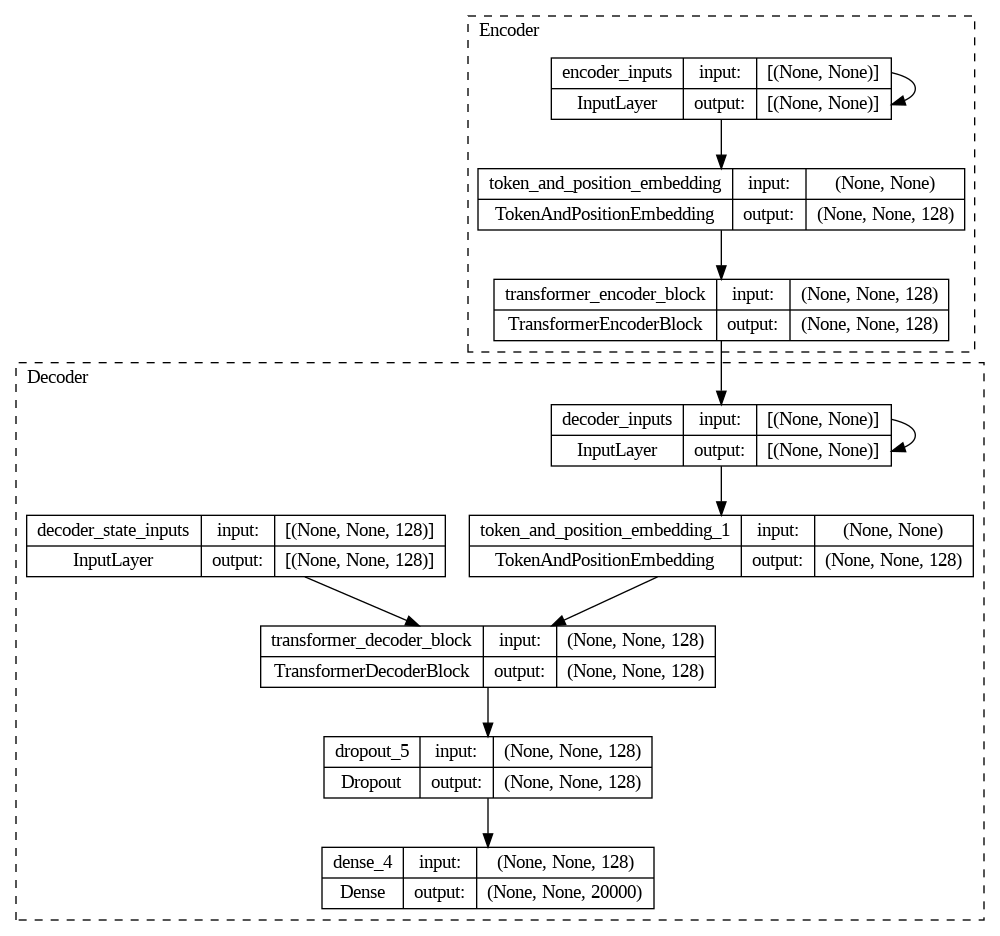

In [ ]:
def create_transformer(encoder, decoder):
    """
    Creates a Transformer model by connecting the encoder and decoder models.

    Args:
    encoder (tfk.Model): The encoder model.
    decoder (tfk.Model): The decoder model.

    Returns:
    tfk.Model: The complete Transformer model.
    """
    encoder_inputs = encoder.input
    decoder_inputs = decoder.input[0]  # First input of the decoder (decoder_inputs)
    encoder_outputs = encoder(encoder_inputs)
    decoder_outputs = decoder([decoder_inputs, encoder_outputs])

    transformer = tfk.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="Transformer")

    return transformer

# Assuming 'encoder' and 'decoder' are already defined
transformer = create_transformer(encoder, decoder)

# Display the model summary and visualize the model
transformer.summary(expand_nested=True)
tfk.utils.plot_model(transformer, show_shapes=True, expand_nested=True, to_file='transformer_model.png')

In [ ]:
learning_rate = 1e-4
optimizer = tfk.optimizers.Adam(learning_rate)
loss = tfk.losses.SparseCategoricalCrossentropy()
metrics = ["accuracy"]

transformer.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
EPOCHS = 100

history = transformer.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
    ]
)

Epoch 1/100
980/980 [==============================] - 209s 195ms/step - loss: 2.7675 - accuracy: 0.8086 - val_loss: 1.0786 - val_accuracy: 0.8446
Epoch 2/100
980/980 [==============================] - 176s 179ms/step - loss: 0.9642 - accuracy: 0.8618 - val_loss: 0.7955 - val_accuracy: 0.8773
Epoch 3/100
980/980 [==============================] - 175s 179ms/step - loss: 0.7435 - accuracy: 0.8857 - val_loss: 0.6330 - val_accuracy: 0.8974
Epoch 4/100
980/980 [==============================] - 175s 179ms/step - loss: 0.6130 - accuracy: 0.9017 - val_loss: 0.5305 - val_accuracy: 0.9115
Epoch 5/100
980/980 [==============================] - 175s 179ms/step - loss: 0.5232 - accuracy: 0.9136 - val_loss: 0.4570 - val_accuracy: 0.9218
Epoch 6/100
980/980 [==============================] - 175s 179ms/step - loss: 0.4566 - accuracy: 0.9225 - val_loss: 0.4029 - val_accuracy: 0.9289
Epoch 7/100
980/980 [==============================] - 175s 179ms/step - loss: 0.4055 - accuracy: 0.9289 - val_loss: 0

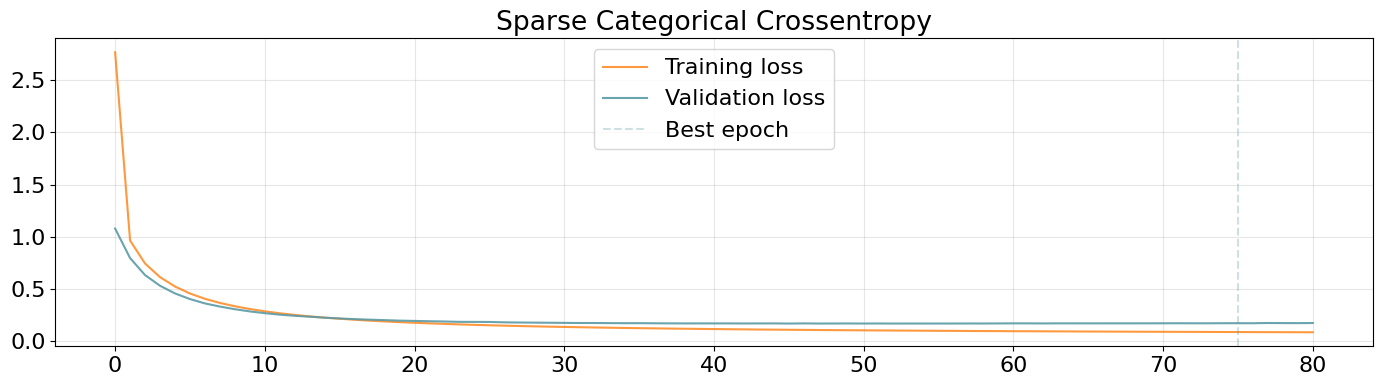

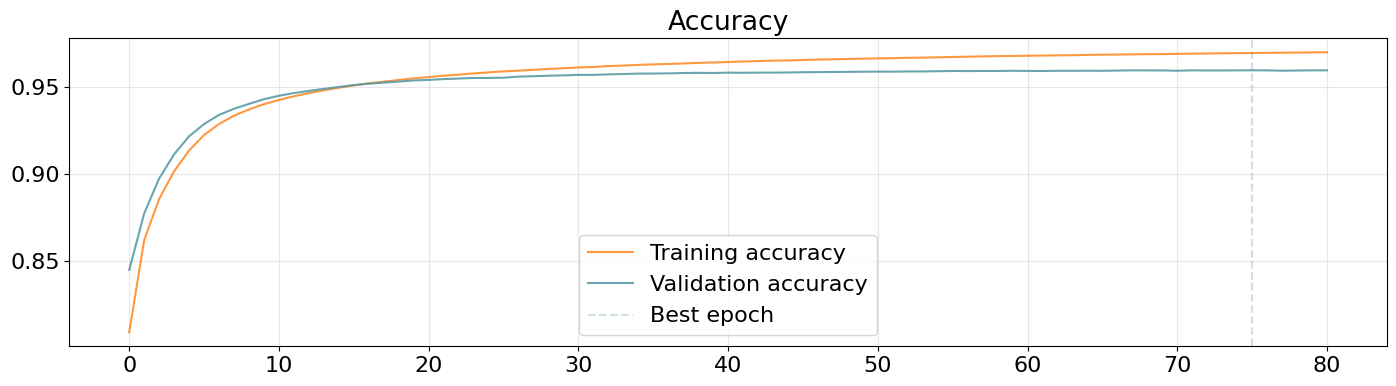

In [ ]:
best_epoch = np.argmax(history.history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history.history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history.history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Sparse Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history.history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
transformer.save('TransformerNMT')

In [ ]:
loaded_transformer = tfk.models.load_model('TransformerNMT')

In [ ]:
max_decoded_sentence_length = 32
ita_vocab = ita_vectorization.get_vocabulary()
ita_index_lookup = dict(zip(range(len(ita_vocab)), ita_vocab))


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ita_vectorization([decoded_sentence])[:, :-1]
        predictions = loaded_transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ita_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

# Example usage
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(f"{input_sentence} --> {translated}")

I'm not Catholic. --> [start] io non sono cattolico [end]
This is crazy. --> [start] questo è pazzo [end]
You're beautiful, you know? --> [start] sei bella sapete [end]
Tom won't talk to you. --> [start] tom non parlerà con te [end]
My opinion is similar to yours. --> [start] la mia opinione è simile alla tua [end]
You've got an hour. --> [start] ha unora [end]
I don't want to see it. --> [start] non la voglio vedere [end]
Tom is planning to be at the party, isn't he? --> [start] tom ha intenzione di essere alla festa vero [end]
What are you buying? --> [start] cosa stai comprando [end]
Well, let's go. --> [start] noi andremo [end]
Tom told Mary. --> [start] tom ha detto a mary [end]
I was in the mountains. --> [start] ero in montagna [end]
That coat is too small for you. --> [start] quel cappotto è troppo piccolo per lei [end]
I love being alone. --> [start] amo essere da sola [end]
I haven't yet met Tom. --> [start] non ho ancora incontrato tom [end]
You may think those shoes are in 

In [ ]:
def print_translation(input_sentence):
    """
    Prints an English sentence and its Italian translation.

    Args:
    input_sentence (str): The English sentence to be translated.
    """
    translated_sentence = decode_sequence(input_sentence)
    print(f"English: {input_sentence}\nItalian: {translated_sentence}")

senence = "The lecture is finished"
print_translation(senence)

English: The lecture is finished
Italian: [start] la lezione è finita [end]


*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*